In [1]:
import tensorflow_hub as hub
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

model_url = 'https://tfhub.dev/google/HRNet/camvid-hrnetv2-w48/1'
seg_model = hub.load(model_url)


In [2]:
def load_image_for_model(path):
    """Load and preprocess image for the segmentation model"""
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = np.expand_dims(image, axis=0) / 255.0
    return image

def extract_road_mask(image_path):
    """Extract precise road mask using the CamVid model"""
    img = load_image_for_model(image_path)
    pred_mask = seg_model.predict(img)
    pred_mask = pred_mask.numpy()
    pred_mask = pred_mask[:, :, :, 1:]
    pred_mask = np.squeeze(pred_mask)
    pred_mask_class = np.argmax(pred_mask, axis=-1)
    road_mask = (pred_mask_class == 17).astype(np.uint8) * 255
    return road_mask, pred_mask_class

def filter_horizontal_lines(lines, max_deviation_degrees=10):
    """Filter lines that are horizontal within max_deviation_degrees from perfect horizontal"""
    if lines is None:
        return []
    
    horizontal_lines = []
    
    for line in lines:
        x1, y1, x2, y2 = line[0]
        angle = np.arctan2(abs(y2 - y1), abs(x2 - x1)) * 180.0 / np.pi
        if angle <= max_deviation_degrees:
            horizontal_lines.append(line)
            
    return horizontal_lines


In [3]:
def speedbump_detection_with_full_visualization(image_path, max_angle_deviation=10, min_line_length=50):
   
    original_img = cv2.imread(image_path)
    if original_img is None:
        print("Error: Could not load image")
        return None
    
    print(f"Processing image: {image_path}")
    print(f"Image dimensions: {original_img.shape}")
    
    road_mask, full_segmentation = extract_road_mask(image_path)
    
    road_only = cv2.bitwise_and(original_img, original_img, mask=road_mask)
    road_gray = cv2.cvtColor(road_only, cv2.COLOR_BGR2GRAY)
    
    thresh = cv2.adaptiveThreshold(road_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                  cv2.THRESH_BINARY, 11, 2)
    thresh_masked = cv2.bitwise_and(thresh, thresh, mask=road_mask)
    
    edges = cv2.Canny(road_gray, threshold1=50, threshold2=10)
    edges_masked = cv2.bitwise_and(edges, edges, mask=road_mask)
    
    lines = cv2.HoughLinesP(edges_masked, 
                           rho=1, 
                           theta=np.pi/180, 
                           threshold=30,      
                           minLineLength=40,   
                           maxLineGap=25)
    
    all_lines_img = cv2.cvtColor(road_gray, cv2.COLOR_GRAY2BGR)
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(all_lines_img, (x1, y1), (x2, y2), (255, 0, 0), 2)  
    
    horizontal_lines = filter_horizontal_lines(lines, max_deviation_degrees=max_angle_deviation)
    
    horizontal_lines_img = cv2.cvtColor(road_gray, cv2.COLOR_GRAY2BGR)
    for line in horizontal_lines:
        x1, y1, x2, y2 = line[0]
        angle = np.arctan2(abs(y2 - y1), abs(x2 - x1)) * 180.0 / np.pi
        cv2.line(horizontal_lines_img, (x1, y1), (x2, y2), (0, 255, 255), 2)
    
    result_img = cv2.cvtColor(road_gray, cv2.COLOR_GRAY2BGR)
    speedbump_detected = False
    detected_lines_info = []
    
    print(f"\nLine Detection Results:")
    print(f"Total lines detected: {len(lines) if lines is not None else 0}")
    print(f"Horizontal lines (≤{max_angle_deviation}°): {len(horizontal_lines)}")
    
    for line in horizontal_lines:
        x1, y1, x2, y2 = line[0]
        line_length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
        angle = np.arctan2(abs(y2 - y1), abs(x2 - x1)) * 180.0 / np.pi
        
        if line_length >= min_line_length:
            cv2.line(result_img, (x1, y1), (x2, y2), (0, 255, 0), 3) 
            speedbump_detected = True
            detected_lines_info.append({
                'length': line_length,
                'angle': angle,
                'coordinates': (x1, y1, x2, y2)
            })
            print(f"✓ Speedbump line: angle={angle:.1f}°, length={line_length:.1f}px")
    
    status_text = 'SPEEDBUMP DETECTED' if speedbump_detected else 'No Speedbump'
    color = (0, 255, 0) if speedbump_detected else (0, 0, 255)
    cv2.putText(result_img, status_text, (10, 30), 
                cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
    cv2.putText(result_img, f'Max Angle: {max_angle_deviation}°', (10, 60), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
    
    return {
        'original_img': original_img,
        'road_mask': road_mask,
        'full_segmentation': full_segmentation,
        'road_only': road_only,
        'road_gray': road_gray,
        'thresh': thresh,
        'thresh_masked': thresh_masked,
        'edges': edges,
        'edges_masked': edges_masked,
        'all_lines_img': all_lines_img,
        'horizontal_lines_img': horizontal_lines_img,
        'result_img': result_img,
        'speedbump_detected': speedbump_detected,
        'total_lines': len(lines) if lines is not None else 0,
        'horizontal_lines': len(horizontal_lines),
        'detected_lines_info': detected_lines_info
    }


In [4]:
def display_all_intermediate_steps(image_path, max_angle_deviation=10):
    
    results = speedbump_detection_with_full_visualization(image_path, max_angle_deviation)
    
    if results is None:
        print("Failed to process image")
        return
    
    fig, axes = plt.subplots(4, 3, figsize=(20, 24))
    fig.suptitle(f'Complete Speedbump Detection Pipeline - Max Angle: {max_angle_deviation}°', fontsize=16)
    
    axes[0, 0].imshow(cv2.cvtColor(results['original_img'], cv2.COLOR_BGR2RGB))
    axes[0, 0].set_title('1. Original Image')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(results['road_mask'], cmap='gray')
    axes[0, 1].set_title('2. Road Segmentation Mask\n(White = Road)')
    axes[0, 1].axis('off')
    
    colored_seg = np.zeros_like(results['original_img'])
    unique_classes = np.unique(results['full_segmentation'])
    colors = plt.cm.tab20(np.linspace(0, 1, len(unique_classes)))
    for i, class_id in enumerate(unique_classes):
        mask = results['full_segmentation'] == class_id
        colored_seg[mask] = (colors[i][:3] * 255).astype(np.uint8)
    
    axes[0, 2].imshow(colored_seg)
    axes[0, 2].set_title('3. All Segmentation Classes\n(Different colors = different classes)')
    axes[0, 2].axis('off')
    
    axes[1, 0].imshow(cv2.cvtColor(results['road_only'], cv2.COLOR_BGR2RGB))
    axes[1, 0].set_title('4. Extracted Road Area\n(Non-road areas blacked out)')
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(results['road_gray'], cmap='gray')
    axes[1, 1].set_title('5. Road Area (Grayscale)')
    axes[1, 1].axis('off')
    
    axes[1, 2].imshow(results['thresh_masked'], cmap='gray')
    axes[1, 2].set_title('6. Adaptive Threshold\n(Applied to road area only)')
    axes[1, 2].axis('off')
    
    axes[2, 0].imshow(results['edges'], cmap='gray')
    axes[2, 0].set_title('7. Canny Edge Detection\n(All edges)')
    axes[2, 0].axis('off')
    
    axes[2, 1].imshow(results['edges_masked'], cmap='gray')
    axes[2, 1].set_title('8. Masked Edges\n(Road edges only)')
    axes[2, 1].axis('off')
    
    axes[2, 2].imshow(cv2.cvtColor(results['all_lines_img'], cv2.COLOR_BGR2RGB))
    axes[2, 2].set_title(f'9. All Detected Lines\n(Blue lines, Total: {results["total_lines"]})')
    axes[2, 2].axis('off')
    
    axes[3, 0].imshow(cv2.cvtColor(results['horizontal_lines_img'], cv2.COLOR_BGR2RGB))
    axes[3, 0].set_title(f'10. Horizontal Lines Only\n(Yellow, Count: {results["horizontal_lines"]})')
    axes[3, 0].axis('off')
    
    axes[3, 1].imshow(cv2.cvtColor(results['result_img'], cv2.COLOR_BGR2RGB))
    axes[3, 1].set_title(f'11. Final Detection\n{"SPEEDBUMP DETECTED" if results["speedbump_detected"] else "NO SPEEDBUMP"}')
    axes[3, 1].axis('off')
    
    stats_text = f"""PIPELINE STATISTICS:
    
Original Image: {results['original_img'].shape[1]}×{results['original_img'].shape[0]}
Road Pixels: {np.sum(results['road_mask'] > 0):,}
Total Lines: {results['total_lines']}
Horizontal Lines: {results['horizontal_lines']}
Angle Threshold: ≤{max_angle_deviation}°

SPEEDBUMP DETECTION:
Status: {'✓ DETECTED' if results['speedbump_detected'] else '✗ NOT DETECTED'}
Lines Found: {len(results['detected_lines_info'])}

DETECTED LINES:"""
    
    for i, line_info in enumerate(results['detected_lines_info']):
        stats_text += f"\nLine {i+1}: {line_info['angle']:.1f}°, {line_info['length']:.0f}px"
    
    axes[3, 2].text(0.05, 0.95, stats_text, transform=axes[3, 2].transAxes, 
                    fontsize=10, verticalalignment='top', fontfamily='monospace')
    axes[3, 2].set_title('12. Detection Statistics')
    axes[3, 2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return results


✓ Image found: C:\Users\pragy\prototype\ml_models\assets\qa_sb_1.png
File size: 194,218 bytes
Processing image: C:\Users\pragy\prototype\ml_models\assets\qa_sb_1.png
Image dimensions: (434, 658, 3)

Line Detection Results:
Total lines detected: 140
Horizontal lines (≤2°): 40
✓ Speedbump line: angle=0.0°, length=368.0px
✓ Speedbump line: angle=0.0°, length=54.0px
✓ Speedbump line: angle=1.6°, length=139.1px
✓ Speedbump line: angle=1.7°, length=99.0px
✓ Speedbump line: angle=1.7°, length=103.0px
✓ Speedbump line: angle=1.9°, length=59.0px
✓ Speedbump line: angle=0.0°, length=63.0px
✓ Speedbump line: angle=0.6°, length=94.0px
✓ Speedbump line: angle=0.0°, length=95.0px
✓ Speedbump line: angle=0.0°, length=109.0px
✓ Speedbump line: angle=0.0°, length=72.0px
✓ Speedbump line: angle=2.0°, length=58.0px
✓ Speedbump line: angle=0.7°, length=81.0px
✓ Speedbump line: angle=0.0°, length=154.0px
✓ Speedbump line: angle=1.0°, length=113.0px
✓ Speedbump line: angle=0.0°, length=63.0px
✓ Speedbump li

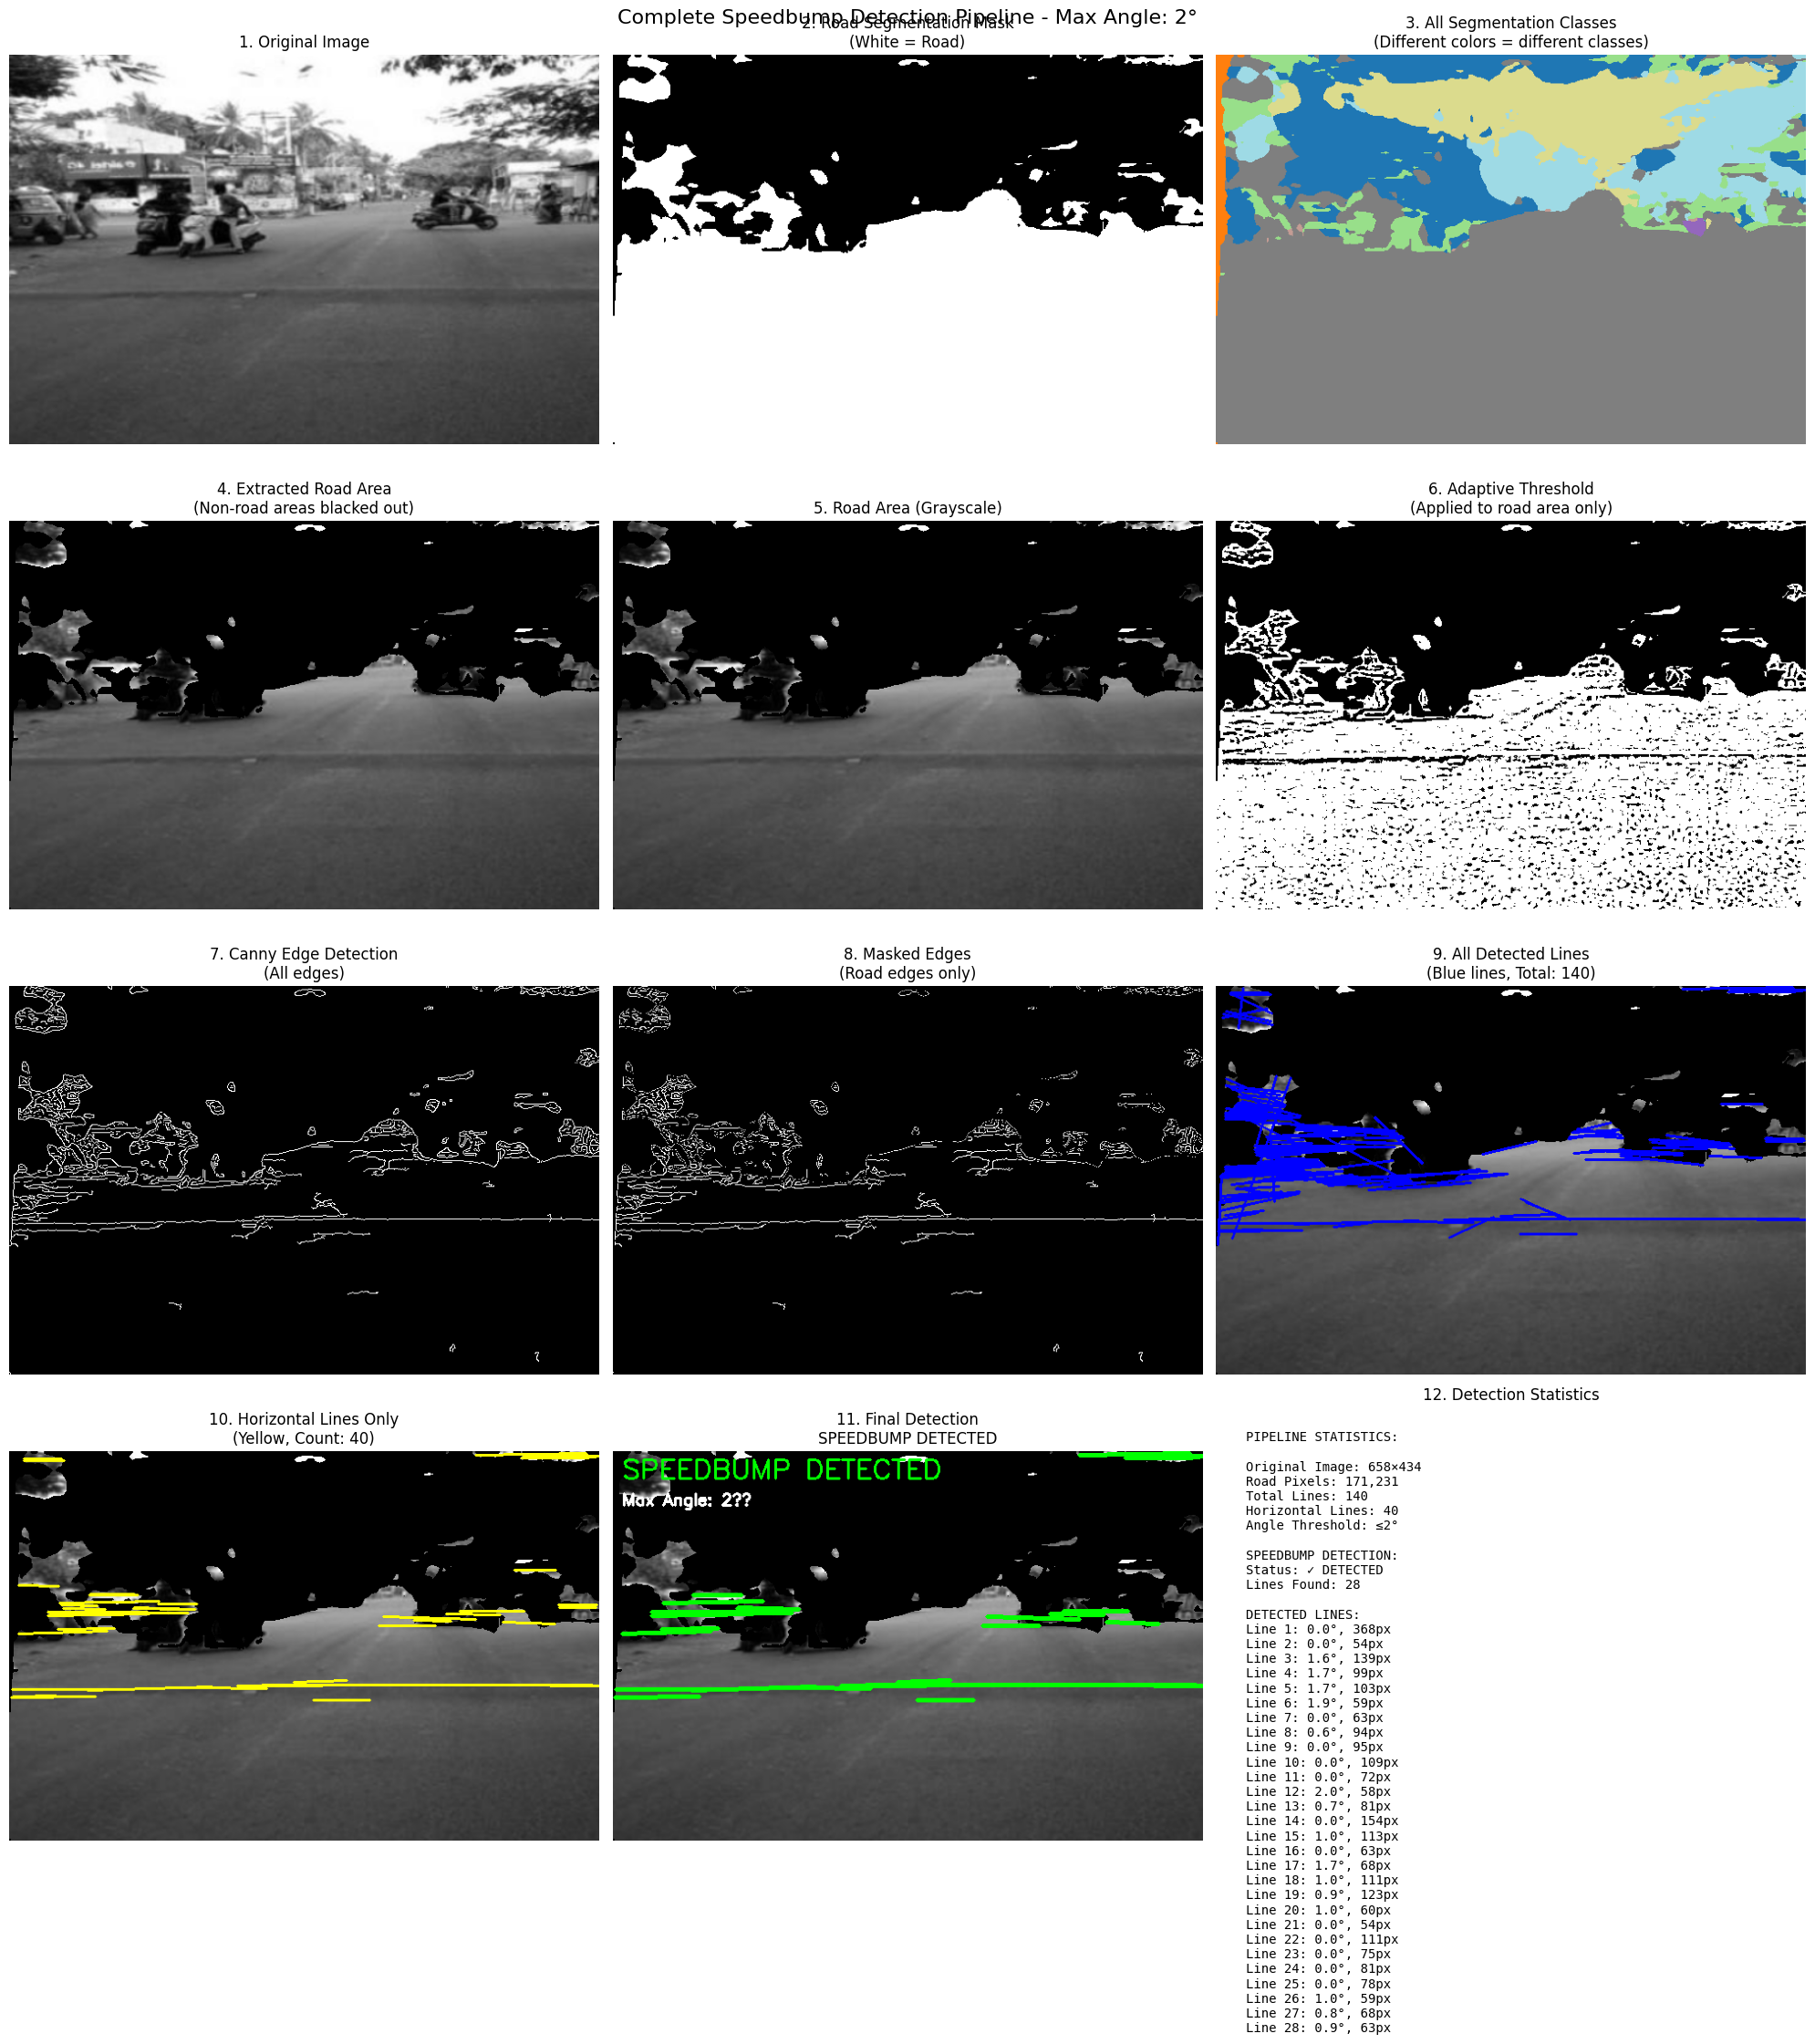

In [5]:
image_path = r"C:\Users\pragy\prototype\ml_models\assets\qa_sb_1.png"

if os.path.exists(image_path):
    print(f"✓ Image found: {image_path}")
    print(f"File size: {os.path.getsize(image_path):,} bytes")
    
    results = display_all_intermediate_steps(image_path, max_angle_deviation=2)
    
else:
    print(f"✗ Image not found: {image_path}")
    print("Available files in directory:")
    try:
        directory = os.path.dirname(image_path)
        if os.path.exists(directory):
            for file in os.listdir(directory):
                print(f"  {file}")
        else:
            print(f"  Directory {directory} does not exist")
    except Exception as e:
        print(f"  Error listing directory: {e}")
